In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!ls "/content/drive/My Drive/Colab Notebooks/Gender Prediction for E-Commerce"

 clr_callback.py
 Dataset
'ECommerceGenderPredictor (ANN) v1.ipynb'
'ECommerceGenderPredictor (ANN) v2.ipynb'
'ECommerceGenderPredictor (LGBM) v1.ipynb'
'ECommerceGenderPredictor (LGBM) v2.ipynb'
 learningratefinder.py
 learning_rate_schedulers.py
 __pycache__


In [0]:
import sys
sys.path.insert(1, '/content/drive/My Drive/Colab Notebooks/Gender Prediction for E-Commerce')

## Importing Packages

In [4]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, BinaryAccuracy
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import LearningRateScheduler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
from learningratefinder import LearningRateFinder
from clr_callback import CyclicLR

## Set file paths for train and prediction datasets

In [0]:
train_dataset = "/content/drive/My Drive/Colab Notebooks/Gender Prediction for E-Commerce/Dataset/train.csv"
prediction_dataset = "/content/drive/My Drive/Colab Notebooks/Gender Prediction for E-Commerce/Dataset/test.csv"

## Data Preprocessing

#### Read data from train and prediction datasets

In [86]:
train_df = pd.read_csv(train_dataset)
predict_df = pd.read_csv(prediction_dataset)
print("Training Data: {}".format(train_df.shape))
print("Prediction Data: {}".format(predict_df.shape))

Training Data: (10500, 5)
Prediction Data: (4500, 4)


#### Extract true labels from train_df

In [87]:
# Encode "gender" field in train_df
train_df['gender_enc'] = train_df['gender'].factorize()[0]
train_df.head()

,session_id,startTime,endTime,ProductList,gender,gender_enc
0,u16159,15/12/14 18:11,15/12/14 18:12,A00002/B00003/C00006/D28435/;A00002/B00003/C00...,female,0
1,u10253,16/12/14 14:35,16/12/14 14:41,A00001/B00009/C00031/D29404/;A00001/B00009/C00...,male,1
2,u19037,01/12/14 15:58,01/12/14 15:58,A00002/B00001/C00020/D16944/,female,0
3,u14556,23/11/14 2:57,23/11/14 3:00,A00002/B00004/C00018/D10284/;A00002/B00004/C00...,female,0
4,u24295,17/12/14 16:44,17/12/14 16:46,A00001/B00001/C00012/D30805/;A00001/B00001/C00...,male,1


In [88]:
# Get count for each label in train_df
train_df.groupby(['gender', 'gender_enc']).size().reset_index().rename(columns={0:'count'})

,gender,gender_enc,count
0,female,0,8192
1,male,1,2308


In [90]:
# Extract "gender_enc" field from train_df into NumPy array
train_y = np.array([train_df['gender_enc'].values]).T
train_df.drop(['gender', 'gender_enc'], inplace=True, axis=1)
print("train_y: {}".format(train_y.shape))
print("Sample train_y data: \n{}".format(train_y[0:10,:]))

train_y: (10500, 1)
Sample train_y data: 
[[0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]]


#### Preprocess data in train_df and predict_df

In [91]:
# Combine the train and predict dataframes
combined_df = train_df.append(predict_df, sort=False, ignore_index=True)
print("combined_df: {}".format(combined_df.shape))

combined_df: (15000, 4)


In [92]:
# Convert "startTime" and "endTime" fields into Datetime
combined_df['startTime'] = pd.to_datetime(combined_df['startTime'], format='%d/%m/%y %H:%M')
combined_df['endTime'] = pd.to_datetime(combined_df['endTime'], format='%d/%m/%y %H:%M')
combined_df.head()

,session_id,startTime,endTime,ProductList
0,u16159,2014-12-15 18:11:00,2014-12-15 18:12:00,A00002/B00003/C00006/D28435/;A00002/B00003/C00...
1,u10253,2014-12-16 14:35:00,2014-12-16 14:41:00,A00001/B00009/C00031/D29404/;A00001/B00009/C00...
2,u19037,2014-12-01 15:58:00,2014-12-01 15:58:00,A00002/B00001/C00020/D16944/
3,u14556,2014-11-23 02:57:00,2014-11-23 03:00:00,A00002/B00004/C00018/D10284/;A00002/B00004/C00...
4,u24295,2014-12-17 16:44:00,2014-12-17 16:46:00,A00001/B00001/C00012/D30805/;A00001/B00001/C00...


In [0]:
# Extract new features from "startTime" field
combined_df['start_rel_year'] = combined_df['startTime'].map(lambda x: x.year)
combined_df['start_rel_quarter'] = combined_df['startTime'].map(lambda x: x.quarter)
combined_df['start_rel_month'] = combined_df['startTime'].map(lambda x: x.month)
combined_df['start_rel_week'] = combined_df['startTime'].map(lambda x: x.week)
combined_df['start_rel_day_year'] = combined_df['startTime'].map(lambda x: x.dayofyear)
combined_df['start_rel_day_month'] = combined_df['startTime'].map(lambda x: x.day)
combined_df['start_rel_day_week'] = combined_df['startTime'].map(lambda x: x.dayofweek)
combined_df['start_rel_day_weekend'] = np.where(combined_df['start_rel_day_week'].isin([5,6]),1,0)
combined_df['start_rel_hour'] = combined_df['startTime'].map(lambda x: x.hour)
combined_df['start_rel_minute'] = combined_df['startTime'].map(lambda x: x.minute)
combined_df['start_minutes_elapsed'] = combined_df['startTime'].map(lambda x: (x - pd.to_datetime(x.date())).seconds / 60.0)

In [0]:
# Extract new features from "endTime" field
combined_df['end_rel_year'] = combined_df['endTime'].map(lambda x: x.year)
combined_df['end_rel_quarter'] = combined_df['endTime'].map(lambda x: x.quarter)
combined_df['end_rel_month'] = combined_df['endTime'].map(lambda x: x.month)
combined_df['end_rel_week'] = combined_df['endTime'].map(lambda x: x.week)
combined_df['end_rel_day_year'] = combined_df['endTime'].map(lambda x: x.dayofyear)
combined_df['end_rel_day_month'] = combined_df['endTime'].map(lambda x: x.day)
combined_df['end_rel_day_week'] = combined_df['endTime'].map(lambda x: x.dayofweek)
combined_df['end_rel_day_weekend'] = np.where(combined_df['end_rel_day_week'].isin([5,6]),1,0)
combined_df['end_rel_hour'] = combined_df['endTime'].map(lambda x: x.hour)
combined_df['end_rel_minute'] = combined_df['endTime'].map(lambda x: x.minute)
combined_df['end_minutes_elapsed'] = combined_df['endTime'].map(lambda x: (x - pd.to_datetime(x.date())).seconds / 60.0)

In [0]:
# Extract time difference between "startTime" and "endTime"
combined_df['time_diff_days'] = (combined_df['endTime'] - combined_df['startTime']).dt.days
combined_df['time_diff_hour'] = (combined_df['endTime'] - combined_df['startTime']).astype('timedelta64[h]')
combined_df['time_diff_minute'] = (combined_df['endTime'] - combined_df['startTime']).astype('timedelta64[m]')

In [0]:
def product_features(row):
    """
    Description: Function to extract below features from "ProductList" field.
      1) Category
      2) Sub-category
      3) Sub-sub-category
      4) Product Name
    """
    item1 = []
    item2 = []
    item3 = []
    item4 = []
    category1 = category2 = category3 = category4 = ","

    for item in row.split(";"):
        item1.append(item.split("/")[0])
        item2.append(item.split("/")[1])
        item3.append(item.split("/")[2])
        item4.append(item.split("/")[3])

    distinct_item1 = list(set(item1))
    distinct_item2 = list(set(item2))
    distinct_item3 = list(set(item3))
    distinct_item4 = list(set(item4))

    category1 = category1.join(distinct_item1)
    category2 = category2.join(distinct_item2)
    category3 = category3.join(distinct_item3)
    category4 = category4.join(distinct_item4)
    
    return pd.Series([category1, category2, category3, category4])

In [0]:
# Extract different categories from "ProductList" field
combined_df['category1'] = np.nan
combined_df['category2'] = np.nan
combined_df['category3'] = np.nan
combined_df['category4'] = np.nan
combined_df[['category1','category2','category3','category4']] = combined_df.apply(lambda x: product_features(x['ProductList']), axis=1)

In [0]:
# Convert categories field into categorical encoded individual fields
combined_df['category1'] = combined_df['category1'].apply(lambda x: x.split(','))
combined_df = combined_df.drop('category1', 1).join(combined_df.category1.str.join('|').str.get_dummies())

combined_df['category2'] = combined_df['category2'].apply(lambda x: x.split(','))
combined_df = combined_df.drop('category2', 1).join(combined_df.category2.str.join('|').str.get_dummies())

combined_df['category3'] = combined_df['category3'].apply(lambda x: x.split(','))
combined_df = combined_df.drop('category3', 1).join(combined_df.category3.str.join('|').str.get_dummies())

combined_df['category4'] = combined_df['category4'].apply(lambda x: x.split(','))
combined_df = combined_df.drop('category4', 1).join(combined_df.category4.str.join('|').str.get_dummies())

In [99]:
# Drop redundant columns
combined_df.drop(['session_id','startTime','endTime','ProductList'], inplace=True, axis=1)
print("combined_df: {}".format(combined_df.shape))

combined_df: (15000, 22385)


In [100]:
# Check if any column has NaN value in dataframe
print("Column with NaN value: {}".format(combined_df.columns[combined_df.isnull().any()].tolist()))

Column with NaN value: []


In [101]:
# Segregate combined_df into train/predict datasets
train_x = combined_df[:10500]
predict_x = combined_df[10500:]

print(train_x.shape)
print(predict_x.shape)

(10500, 22385)
(4500, 22385)


#### Scale the train_x/predict_x arrays

In [0]:
scaler_x = StandardScaler().fit(train_x)
train_x = scaler_x.transform(train_x)
predict_x = scaler_x.transform(predict_x)

#### Dimentionality Reduction using PCA

In [103]:
# Create and fit the PCA model
pca = PCA(.90)
pca.fit(train_x)
print(pca.n_components_)

6362


In [0]:
train_x = pca.transform(train_x)
predict_x = pca.transform(predict_x)
train_x_full = np.copy(train_x)
train_y_full = np.copy(train_y)

#### Split training data into train/validation/test datasets

In [105]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.085, random_state=1)
for train_index, test_index in sss.split(train_x, train_y):
    train_x, test_x = train_x[train_index], train_x[test_index]
    train_y, test_y = train_y[train_index], train_y[test_index]

print("------------------------- Training Dataset -------------------------")
print("train_x shape: {}".format(train_x.shape))
print("train_y shape: {}".format(train_y.shape))

print("\n------------------------- Test Dataset -------------------------")
print("test_x shape: {}".format(test_x.shape))
print("test_y shape: {}".format(test_y.shape))

------------------------- Training Dataset -------------------------
train_x shape: (9607, 6362)
train_y shape: (9607, 1)

------------------------- Test Dataset -------------------------
test_x shape: (893, 6362)
test_y shape: (893, 1)


In [106]:
train_df = pd.DataFrame({'Gender': train_y[:, 0]})
train_df.groupby(['Gender']).size().reset_index().rename(columns={0:'Count'})

,Gender,Count
0,0,7495
1,1,2112


In [107]:
test_df = pd.DataFrame({'Gender': test_y[:, 0]})
test_df.groupby(['Gender']).size().reset_index().rename(columns={0:'Count'})

,Gender,Count
0,0,697
1,1,196


## Save the datasets in NPZ file (for reusability)

In [0]:
np.savez_compressed('/content/drive/My Drive/Colab Notebooks/Gender Prediction for E-Commerce/Dataset/ECommerce_Gender_dataset_ANN_v2.npz',
                    Xtrain_full=train_x_full, Ytrain_full=train_y_full,
                    Xtrain=train_x, Ytrain=train_y,
                    Xtest=test_x, Ytest=test_y,
                    Xpredict=predict_x)

## Load datasets from the NPZ file

In [1]:
processed_dataset = np.load('/content/drive/My Drive/Colab Notebooks/Gender Prediction for E-Commerce/Dataset/ECommerce_Gender_dataset_ANN_v2.npz', allow_pickle=True)

Xtrain_full, Ytrain_full = processed_dataset['Xtrain_full'], processed_dataset['Ytrain_full']
Xtrain, Ytrain = processed_dataset['Xtrain'], processed_dataset['Ytrain']
Xtest, Ytest = processed_dataset['Xtest'], processed_dataset['Ytest']
Xpredict = processed_dataset['Xpredict']

print("------------------------- Training Dataset -------------------------")
print("Xtrain_full shape: {}".format(Xtrain_full.shape))
print("Ytrain_full shape: {}".format(Ytrain_full.shape))
print("Xtrain shape: {}".format(Xtrain.shape))
print("Ytrain shape: {}".format(Ytrain.shape))

print("\n------------------------- Test Dataset -------------------------")
print("Xtest shape: {}".format(Xtest.shape))
print("Ytest shape: {}".format(Ytest.shape))

print("\n------------------------- Prediction Dataset -------------------------")
print("Xpredict shape: {}".format(Xpredict.shape))

NameError: name 'np' is not defined

## Build the model

In [0]:
def nn_model(input_shape, output_bias=None):

    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    # Input Layer
    x_input = Input(shape=(input_shape, ), name='INPUT')
    
    # Fully-connected Layer 1
    x = Dense(units=36, name='FC-1', activation='relu', kernel_regularizer=l1_l2(l1=0.25, l2=0.25), bias_regularizer=l1_l2(l1=0.25, l2=0.25))(x_input)
    x = BatchNormalization(name='BN_FC-1')(x)
    x = Dropout(rate=0.15, name='DROPOUT_FC-1')(x)

    # Fully-connected Layer 2
    x = Dense(units=25, name='FC-2', activation='relu', kernel_regularizer=l1_l2(l1=0.05, l2=0.05), bias_regularizer=l1_l2(l1=0.05, l2=0.05))(x)
    x = BatchNormalization(name='BN_FC-2')(x)
    x = Dropout(rate=0.25, name='DROPOUT_FC-2')(x)

    # Fully-connected Layer 3
    x = Dense(units=25, name='FC-3', activation='relu', kernel_regularizer=l1_l2(l1=0.05, l2=0.05), bias_regularizer=l1_l2(l1=0.05, l2=0.05))(x)
    x = BatchNormalization(name='BN_FC-3')(x)
    x = Dropout(rate=0.25, name='DROPOUT_FC-3')(x)

    # Fully-connected Layer 4
    x = Dense(units=4, name='FC-4', activation='relu', kernel_regularizer=l1_l2(l1=0.05, l2=0.05), bias_regularizer=l1_l2(l1=0.05, l2=0.05))(x)
    x = BatchNormalization(name='BN_FC-4')(x)

    # Output Layer
    x = Dense(units=1, activation='sigmoid', name='OUTPUT', bias_initializer=output_bias)(x)

    # Create Keras Model instance
    model = Model(inputs=x_input, outputs=x, name='ECommerce_Gender_Predictor')

    return model

In [0]:
# Define the model hyperparameters
max_iterations = 125
mini_batch_size = 1024
min_lr = 1e-5
max_lr = 1e-2

step_size = 4 * (Xtrain.shape[0] // mini_batch_size)
clr_method = 'triangular2'

In [329]:
# Examine class imbalance
train_df = pd.DataFrame({'gender_enc': Ytrain[:, 0]})
neg, pos = np.bincount(train_df['gender_enc'])
total = neg + pos
print('Total: {} \nMale: {} ({:.2f}% of total) \nFemale: {} ({:.2f}% of total)'.format(total, pos, 100 * pos / total, neg, 100 * neg / total))

Total: 9607 
Male: 2112 (21.98% of total) 
Female: 7495 (78.02% of total)


In [330]:
# Calculate initial bias
initial_bias = np.log([pos/neg])
initial_bias

array([-1.26660077])

In [331]:
# Calculate class weights
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.64
Weight for class 1: 2.27


In [332]:
# Create the model
model = nn_model(Xtrain.shape[1], initial_bias)

# Compile model to configure the learning process
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=min_lr), metrics=[BinaryAccuracy(name='accuracy'), AUC(name='auc')])

# Display details of all ANN layers
model.summary()

Model: "ECommerce_Gender_Predictor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 6362)]            0         
_________________________________________________________________
FC-1 (Dense)                 (None, 36)                229068    
_________________________________________________________________
BN_FC-1 (BatchNormalization) (None, 36)                144       
_________________________________________________________________
DROPOUT_FC-1 (Dropout)       (None, 36)                0         
_________________________________________________________________
FC-2 (Dense)                 (None, 25)                925       
_________________________________________________________________
BN_FC-2 (BatchNormalization) (None, 25)                100       
_________________________________________________________________
DROPOUT_FC-2 (Dropout)       (None, 25) 

Epoch 1/205
10/10 [==============================] - 0s 25ms/step - loss: 853.6325 - accuracy: 0.6568 - auc: 0.4985
Epoch 2/205
10/10 [==============================] - 0s 23ms/step - loss: 853.6329 - accuracy: 0.6611 - auc: 0.5041
Epoch 3/205
10/10 [==============================] - 0s 24ms/step - loss: 853.6306 - accuracy: 0.6522 - auc: 0.5033
Epoch 4/205
10/10 [==============================] - 0s 23ms/step - loss: 853.6373 - accuracy: 0.6554 - auc: 0.4969
Epoch 5/205
10/10 [==============================] - 0s 25ms/step - loss: 853.6344 - accuracy: 0.6525 - auc: 0.4932
Epoch 6/205
10/10 [==============================] - 0s 24ms/step - loss: 853.6299 - accuracy: 0.6563 - auc: 0.5113
Epoch 7/205
10/10 [==============================] - 0s 24ms/step - loss: 853.6332 - accuracy: 0.6550 - auc: 0.4995
Epoch 8/205
10/10 [==============================] - 0s 24ms/step - loss: 853.6346 - accuracy: 0.6580 - auc: 0.4999
Epoch 9/205
10/10 [==============================] - 0s 24ms/step - loss

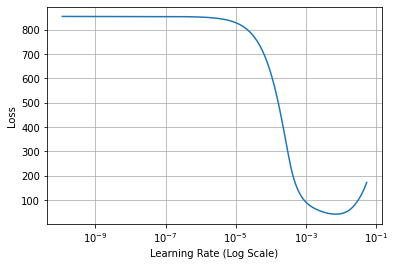

In [171]:
# Learning Rate Finder
lrf = LearningRateFinder(model)
lrf.find((Xtrain, Ytrain),
         startLR=1e-10, endLR=1e+1,
         stepsPerEpoch=np.ceil((len(Xtrain) / float(mini_batch_size))),
         batchSize=mini_batch_size)
lrf.plot_loss()
plt.grid()
plt.show()

In [0]:
# Define K-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
cvscores = []
y_pred = 0
loss_values = {}
acc_values = {}
auc_values = {}

In [334]:
# Train the model using K-fold
counter = 0

for train, val in kfold.split(Xtrain, Ytrain):
    counter += 1

    train_x, train_y = Xtrain[train], Ytrain[train]
    val_x, val_y = Xtrain[val], Ytrain[val]
    print("train_x: {}   train_y: {}   \nval_x: {}    val_y: {}".format(train_x.shape, train_y.shape, val_x.shape, val_y.shape))

    # Examine class imbalance
    train_df = pd.DataFrame({'gender_enc': train_y[:, 0]})
    neg, pos = np.bincount(train_df['gender_enc'])
    total = neg + pos
    print('Training Data  \n------------------  \nTotal: {} \nMale: {} ({:.2f}% of total) \nFemale: {} ({:.2f}% of total)'.
          format(total, pos, 100 * pos / total, neg, 100 * neg / total))

    val_df = pd.DataFrame({'gender_enc': val_y[:, 0]})
    val_neg, val_pos = np.bincount(val_df['gender_enc'])
    val_total = val_neg + val_pos
    print('Validation Data  \n------------------  \nTotal: {} \nMale: {} ({:.2f}% of total) \nFemale: {} ({:.2f}% of total)'.
          format(val_total, val_pos, 100 * val_pos / val_total, val_neg, 100 * val_neg / val_total))

    # Calculate initial bias
    initial_bias = np.log([pos/neg])
    print("Initial Bias: {}".format(initial_bias))

    # Calculate class weights
    weight_for_0 = (1 / neg)*(total)/2.0 
    weight_for_1 = (1 / pos)*(total)/2.0
    class_weight = {0: weight_for_0, 1: weight_for_1}
    print('Weight for class 0: {:.2f}'.format(weight_for_0))
    print('Weight for class 1: {:.2f}'.format(weight_for_1))

    # Create the model
    model = nn_model(Xtrain.shape[1], initial_bias)

    # Compile model to configure the learning process
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=min_lr), metrics=[BinaryAccuracy(name='accuracy'), AUC(name='auc')])

    # Triangular learning rate policy
    clr = CyclicLR(base_lr=min_lr, max_lr=max_lr, mode=clr_method, step_size=step_size)

    # Fit the model
    history = model.fit(x=train_x, y=train_y, batch_size=mini_batch_size,
                    callbacks=[clr], workers=5, class_weight=class_weight,
                    epochs=100, validation_data=(val_x, val_y))

    # Store the score values on validation dataset
    scores = model.evaluate(x=Xtest, y=Ytest, verbose=0)
    print("Counter {}: \nTest Loss: {} \nTest Accuracy: {} \nTest AUC: {} \n\n".format(counter, scores[0], scores[1], scores[2]))
    cvscores.append(scores[1])

    # Run predictions
    pred1 = model.predict(x=Xtest)
    y_pred += pred1

    # Store the history object values for learning curves plotting
    loss_values["train_loss_"+str(counter)] = history.history['loss']
    loss_values["val_loss_"+str(counter)] = history.history['val_loss']
    acc_values["train_acc_"+str(counter)] = history.history['accuracy']
    acc_values["val_acc_"+str(counter)] = history.history['val_accuracy']
    auc_values["train_auc_"+str(counter)] = history.history['auc']
    auc_values["val_auc_"+str(counter)] = history.history['val_auc']

print("%.2f (+/- %.2f)" % (np.mean(cvscores), np.std(cvscores)))
y_pred /= float(counter)

train_x: (7685, 6362)   train_y: (7685, 1)   
val_x: (1922, 6362)    val_y: (1922, 1)
Training Data  
------------------  
Total: 7685 
Male: 1689 (21.98% of total) 
Female: 5996 (78.02% of total)
Validation Data  
------------------  
Total: 1922 
Male: 423 (22.01% of total) 
Female: 1499 (77.99% of total)
Initial Bias: [-1.26695594]
Weight for class 0: 0.64
Weight for class 1: 2.28
Epoch 1/100
8/8 [==============================] - 1s 89ms/step - loss: 806.1811 - accuracy: 0.7275 - auc: 0.5032 - val_loss: 530.4623 - val_accuracy: 0.7799 - val_auc: 0.4876
Epoch 2/100
8/8 [==============================] - 0s 36ms/step - loss: 326.3554 - accuracy: 0.7256 - auc: 0.4944 - val_loss: 291.0944 - val_accuracy: 0.7799 - val_auc: 0.5225
Epoch 3/100
8/8 [==============================] - 0s 37ms/step - loss: 293.9352 - accuracy: 0.7356 - auc: 0.5257 - val_loss: 191.9279 - val_accuracy: 0.7799 - val_auc: 0.5037
Epoch 4/100
8/8 [==============================] - 0s 34ms/step - loss: 173.9710 - ac

## Plot the learning curves

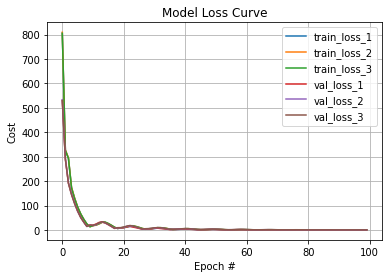

In [335]:
plt.plot(loss_values["train_loss_1"], label='train_loss_1')
plt.plot(loss_values["train_loss_2"], label='train_loss_2')
plt.plot(loss_values["train_loss_3"], label='train_loss_3')
plt.plot(loss_values["val_loss_1"], label='val_loss_1')
plt.plot(loss_values["val_loss_2"], label='val_loss_2')
plt.plot(loss_values["val_loss_3"], label='val_loss_3')
plt.ylabel('Cost')
plt.xlabel('Epoch #')
plt.title("Model Loss Curve")
plt.legend()
plt.grid()
plt.show()

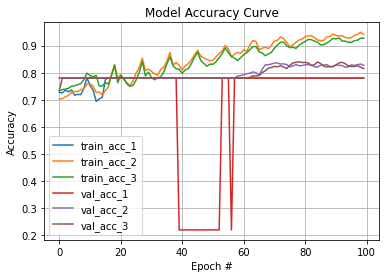

In [336]:
plt.plot(acc_values['train_acc_1'], label='train_acc_1')
plt.plot(acc_values['train_acc_2'], label='train_acc_2')
plt.plot(acc_values['train_acc_3'], label='train_acc_3')
plt.plot(acc_values['val_acc_1'], label='val_acc_1')
plt.plot(acc_values['val_acc_2'], label='val_acc_2')
plt.plot(acc_values['val_acc_3'], label='val_acc_3')
plt.ylabel('Accuracy')
plt.xlabel('Epoch #')
plt.title("Model Accuracy Curve")
plt.legend()
plt.grid()
plt.show()

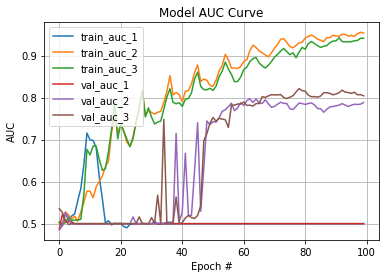

In [337]:
plt.plot(auc_values['train_auc_1'], label='train_auc_1')
plt.plot(auc_values['train_auc_2'], label='train_auc_2')
plt.plot(auc_values['train_auc_3'], label='train_auc_3')
plt.plot(auc_values['val_auc_1'], label='val_auc_1')
plt.plot(auc_values['val_auc_2'], label='val_auc_2')
plt.plot(auc_values['val_auc_3'], label='val_auc_3')
plt.ylabel('AUC')
plt.xlabel('Epoch #')
plt.title("Model AUC Curve")
plt.legend()
plt.grid()
plt.show()

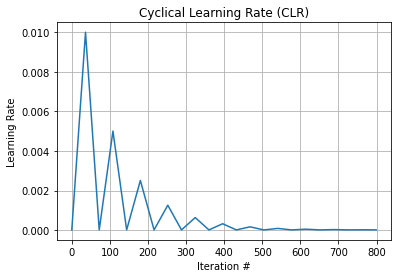

In [338]:
plt.plot(clr.history["lr"])
plt.ylabel('Learning Rate')
plt.xlabel('Iteration #')
plt.title("Cyclical Learning Rate (CLR)")
plt.grid()
plt.show()

## Validate the model

In [0]:
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

In [340]:
#Print accuracy
acc_score = accuracy_score(Ytest, y_pred_binary)
print('Overall accuracy of ANN model:', acc_score)

Overall accuracy of ANN model: 0.832026875699888


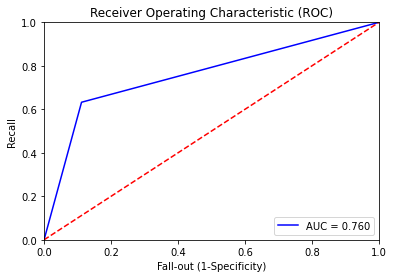

AUC score: 0.7603724416595907


In [341]:
#Print Area Under Curve
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(Ytest, y_pred_binary)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc)

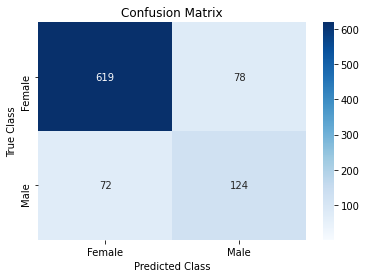

In [342]:
#Print Confusion Matrix
cm = confusion_matrix(Ytest, y_pred_binary)
labels = ['Female', 'Male']
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.5);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

## Train the model on entire training data

In [0]:
# Define K-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
y_pred = 0

In [344]:
# Train the model using K-fold
counter = 0

for train, val in kfold.split(Xtrain_full, Ytrain_full):
    counter += 1
    train_x, train_y = Xtrain_full[train], Ytrain_full[train]
    val_x, val_y = Xtrain_full[val], Ytrain_full[val]

    # Examine class imbalance
    train_df = pd.DataFrame({'gender_enc': train_y[:, 0]})
    neg, pos = np.bincount(train_df['gender_enc'])
    total = neg + pos
    print('Total: {} \nMale: {} ({:.2f}% of total) \nFemale: {} ({:.2f}% of total)'.format(total, pos, 100 * pos / total, neg, 100 * neg / total))

    # Calculate initial bias
    initial_bias = np.log([pos/neg])
    print("Initial Bias: {}".format(initial_bias))

    # Calculate class weights
    weight_for_0 = (1 / neg)*(total)/2.0 
    weight_for_1 = (1 / pos)*(total)/2.0
    class_weight = {0: weight_for_0, 1: weight_for_1}
    print('Weight for class 0: {:.2f}'.format(weight_for_0))
    print('Weight for class 1: {:.2f}'.format(weight_for_1))

    # Create the model
    model = nn_model(Xtrain_full.shape[1], initial_bias)

    # Compile model to configure the learning process
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=min_lr), metrics=[BinaryAccuracy(name='accuracy'), AUC(name='auc')])

    # Triangular learning rate policy
    clr = CyclicLR(base_lr=min_lr, max_lr=max_lr, mode=clr_method, step_size=step_size)

    # Fit the model
    history = model.fit(x=train_x, y=train_y, batch_size=mini_batch_size,
                    callbacks=[clr], workers=5, class_weight=class_weight,
                    epochs=100, validation_data=(val_x, val_y))

    # Run predictions
    pred1 = model.predict(x=Xpredict)
    y_pred += pred1

y_pred /= float(counter)

Total: 8400 
Male: 1847 (21.99% of total) 
Female: 6553 (78.01% of total)
Initial Bias: [-1.26636026]
Weight for class 0: 0.64
Weight for class 1: 2.27
Epoch 1/100
9/9 [==============================] - 1s 78ms/step - loss: 776.1777 - accuracy: 0.7018 - auc: 0.5118 - val_loss: 451.3193 - val_accuracy: 0.7762 - val_auc: 0.4911
Epoch 2/100
9/9 [==============================] - 0s 34ms/step - loss: 299.3413 - accuracy: 0.7111 - auc: 0.5269 - val_loss: 333.1636 - val_accuracy: 0.7800 - val_auc: 0.5212
Epoch 3/100
9/9 [==============================] - 0s 34ms/step - loss: 252.4207 - accuracy: 0.7194 - auc: 0.5484 - val_loss: 167.5177 - val_accuracy: 0.7805 - val_auc: 0.5479
Epoch 4/100
9/9 [==============================] - 0s 34ms/step - loss: 157.8407 - accuracy: 0.7046 - auc: 0.5203 - val_loss: 129.7206 - val_accuracy: 0.7805 - val_auc: 0.4973
Epoch 5/100
9/9 [==============================] - 0s 37ms/step - loss: 112.2846 - accuracy: 0.7154 - auc: 0.5380 - val_loss: 90.0134 - val_accu

In [345]:
# Convert prediction probabilies into binary
y_pred_binary = np.where(y_pred > 0.5, 1, 0)
temp_df = pd.DataFrame(y_pred_binary, columns=['prediction'])
temp_df['prediction'] = temp_df['prediction'].apply(lambda x: 'female' if x == 0 else 'male')
temp_df.head()

,prediction
0,female
1,female
2,female
3,female
4,female


## Create submission file

In [0]:
submit_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Gender Prediction for E-Commerce/Dataset/sample_submission.csv")
submit_df['gender'] = temp_df['prediction']
submit_df.to_csv("predictions.csv", index=False)